In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [3]:
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    Samplers,
    SequentialEvaluator,
    MultiprocessingEvaluator,
)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

In [10]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3)

In [11]:
dike_model

In [12]:
import copy

for unc in dike_model.uncertainties:
    print(f'{repr(unc)}\n')

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])

CategoricalParameter('discount rate 1', [0, 1, 2, 3])

CategoricalParameter('discount rate 2', [0, 1, 2, 3])

IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)

RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)

RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)

CategoricalParameter('A.1_Brate', [0, 1, 2])

RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)

RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)

CategoricalParameter('A.2_Brate', [0, 1, 2])

RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)

RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name

In [26]:
for policy in dike_model.levers:
    print(f'{repr(policy)}\n')

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)

IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)

IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)

IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)

IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)

IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)

IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)

IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)

IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)

IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None,

In [13]:
for outcome in dike_model.outcomes:
    print(f'{repr(outcome)}\n')

ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x000002502030D120>)

ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x000002502030D120>)

ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x000002502030D120>)

ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x000002502030D120>)

ScalarOutcome('A.3 Total Costs', variable_name=('A.3_Expected Annual Damage', 'A.3_Dike Investment Costs'), function=<function sum_over at 0x000002502030D120>)

ScalarOutcome('A.3_Expected Number of Deaths', variable_name=('A.3_Expected Number of Deaths',), function=<function sum_over at 0x000002502030D120>)

ScalarOutcome('A.4 Total Costs', variable_name=('A.4_Expected Annua

In [33]:
# defining specific policies
# for example, policy 1 is about extra protection in upper boundary
# policy 2 is about extra protection in lower boundary
# policy 3 is extra protection in random locations

def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}


policies = [
    Policy(
        "policy 1",
        **dict(
            get_do_nothing_dict(),
            **{"0_RfR 0": 0, "0_RfR 1": 0, "0_RfR 2": 0, "A.1_DikeIncrease 0": 0}
        )
    ),
    Policy(
        "policy 2",
        **dict(
            get_do_nothing_dict(),
            **{"A.1_DikeIncrease 0": 10, "A.3_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "policy 3",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 0": 1, "A.1_DikeIncrease 0": 10, "A.3_DikeIncrease 0": 10}
        )
    ),
    Policy(
        "policy 4",
        **dict(
            get_do_nothing_dict(),
            **{"1_RfR 0": 1, "2_RfR 0": 1, "3_RfR 0": 1, "4_RfR 0": 1, "0_RfR 0": 1,}
        )
    ),
    Policy(
        "policy 5",
        **dict(
            get_do_nothing_dict(),
            **{"A.1_DikeIncrease 0": 10, "A.2_DikeIncrease 0": 10, "A.3_DikeIncrease 0": 10, "A.4_DikeIncrease 0": 10, "A.5_DikeIncrease 0": 10}
        )
    )
]

In [34]:
# pass the policies list to EMA workbench experiment runs
n_scenarios = 32
with MultiprocessingEvaluator(dike_model, n_processes=-2) as evaluator:
    experiments, results = evaluator.perform_experiments(n_scenarios, policies,
                                                         uncertainty_sampling=Samplers.SOBOL)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1280 scenarios * 5 policies * 1 model(s) = 6400 experiments
100%|██████████████████████████████████████| 6400/6400 [13:50<00:00,  7.70it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [35]:
from ema_workbench.em_framework import get_SALib_problem

In [36]:
problem = get_SALib_problem(dike_model.uncertainties)
problem

{'num_vars': 19,
 'names': ['A.0_ID flood wave shape',
  'A.1_Bmax',
  'A.1_Brate',
  'A.1_pfail',
  'A.2_Bmax',
  'A.2_Brate',
  'A.2_pfail',
  'A.3_Bmax',
  'A.3_Brate',
  'A.3_pfail',
  'A.4_Bmax',
  'A.4_Brate',
  'A.4_pfail',
  'A.5_Bmax',
  'A.5_Brate',
  'A.5_pfail',
  'discount rate 0',
  'discount rate 1',
  'discount rate 2'],
 'bounds': [(0, 133),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (30, 350),
  (0, 3),
  (0, 1),
  (0, 4),
  (0, 4),
  (0, 4)]}

In [37]:
res_df = pd.DataFrame(results)
res_df.keys()

Index(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs',
       'A.2_Expected Number of Deaths', 'A.3 Total Costs',
       'A.3_Expected Number of Deaths', 'A.4 Total Costs',
       'A.4_Expected Number of Deaths', 'A.5 Total Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs'],
      dtype='object')

In [29]:
from SALib.analyze import sobol

In [38]:
from ema_workbench.analysis import feature_scoring

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

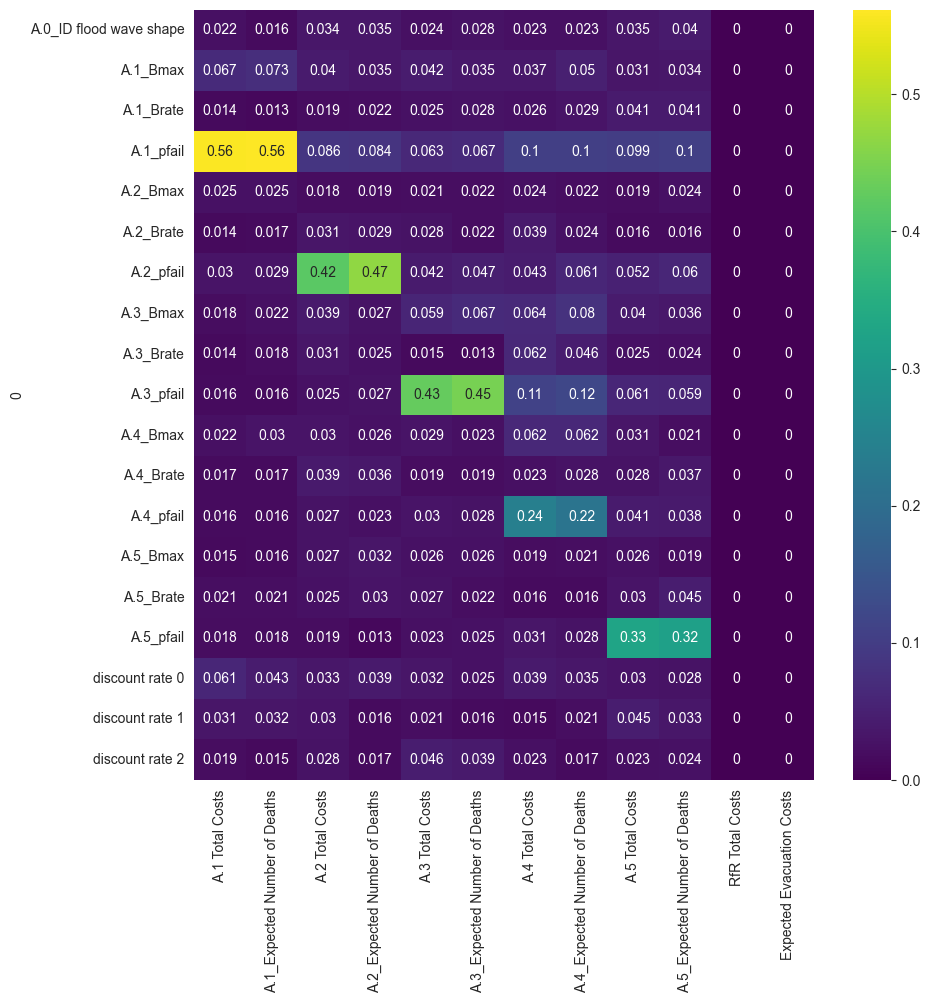

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

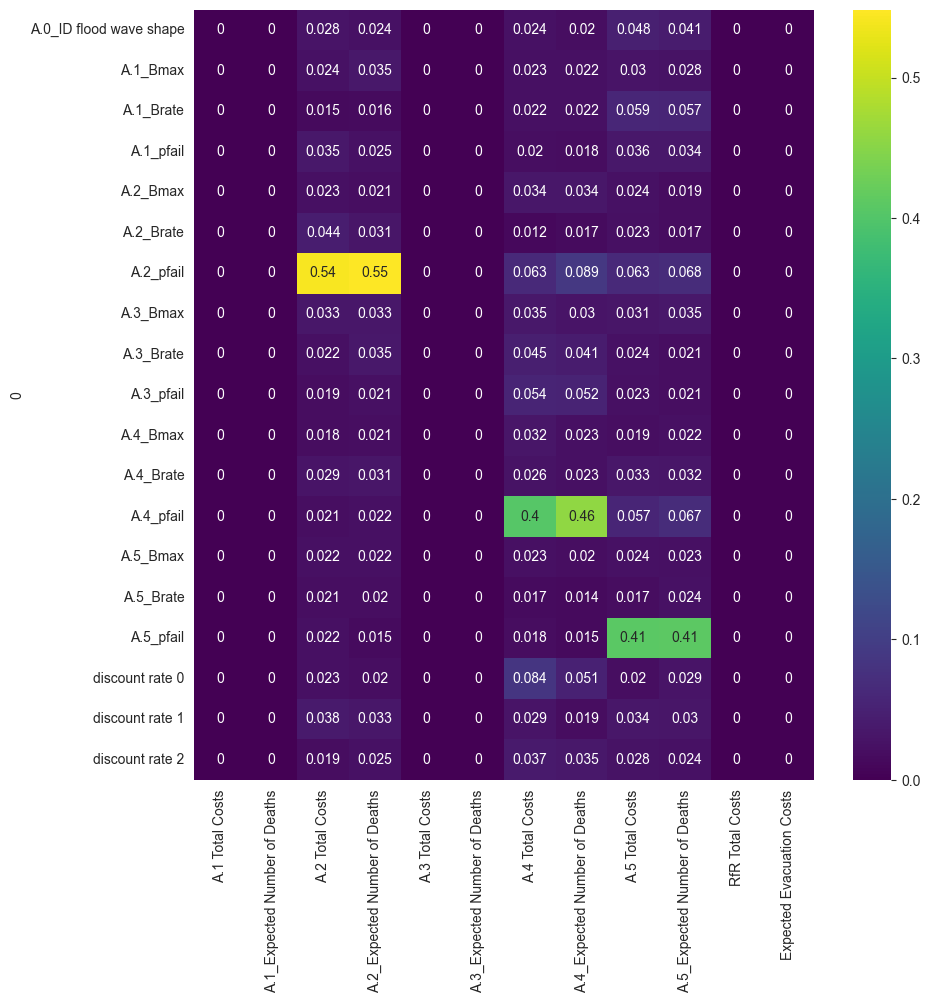

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

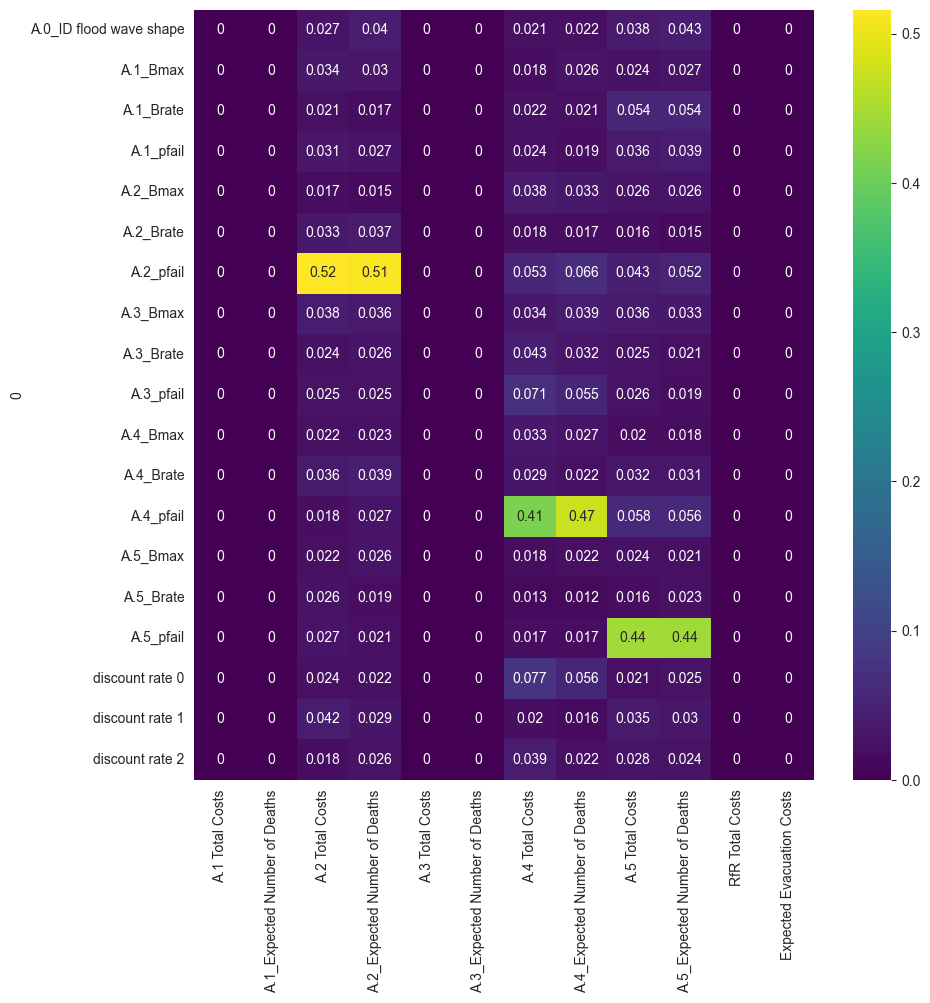

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

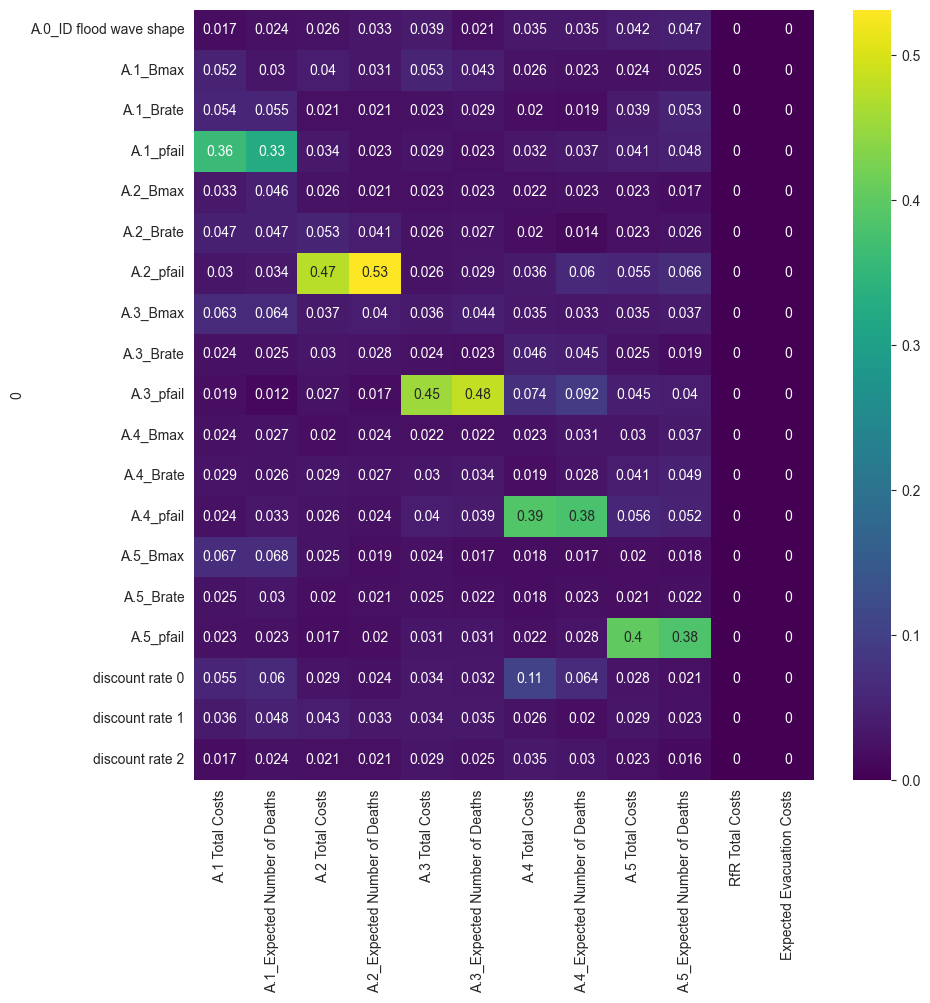

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

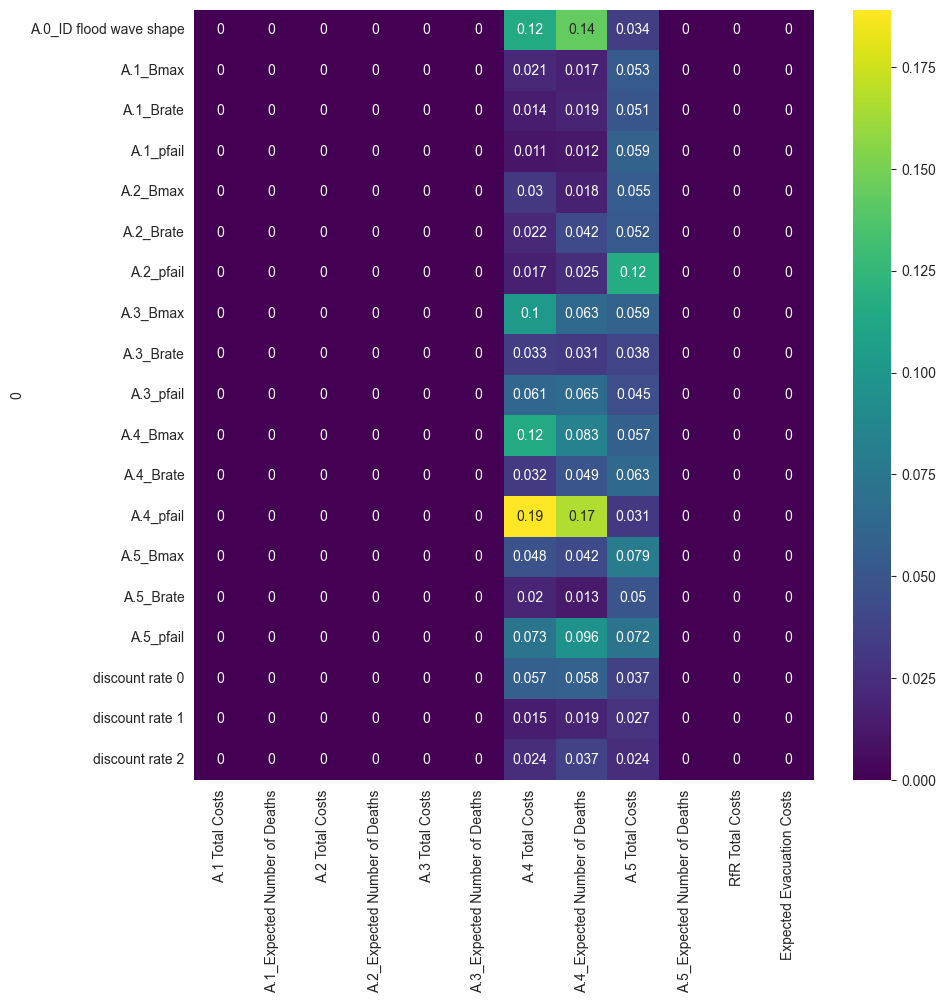

In [39]:
import seaborn as sns
cleaned_experiments = experiments.drop(columns=[l.name for l in dike_model.levers])
# cleaned_experiments = experiments.drop(columns=[l.name for l in dike_model.uncertainties])

for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    subset_results = {k:v[logical] for k,v in results.items()}
    scores = feature_scoring.get_feature_scores_all(cleaned_experiments[logical],
                                                             subset_results)
    plt.figure(figsize=(10,10))
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.show()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


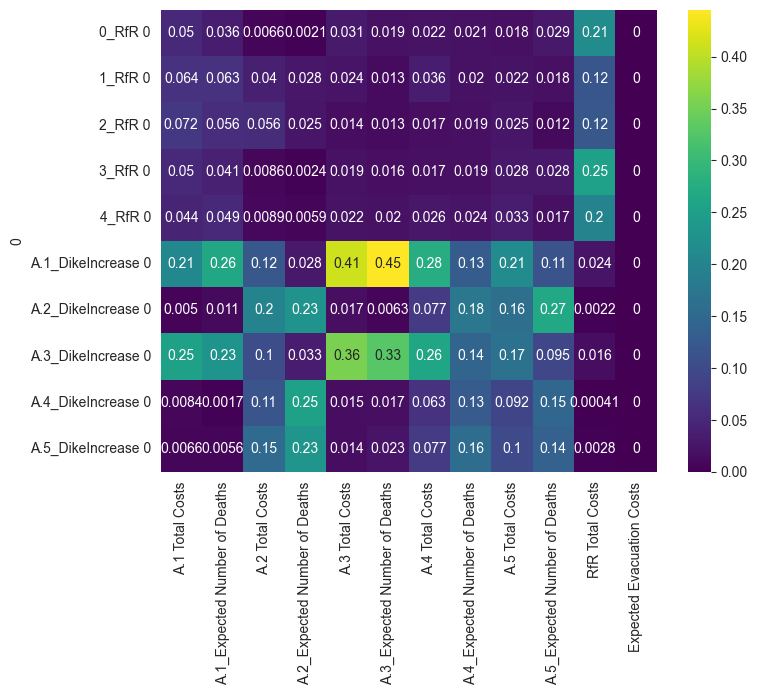

In [44]:
scores = np.round(feature_scoring.get_feature_scores_all(experiments.drop(columns=[l.name for l in dike_model.uncertainties]), results), 5)

selected_rows = ['0_RfR 0', '1_RfR 0', '2_RfR 0', '3_RfR 0', '4_RfR 0', 'A.1_DikeIncrease 0', 'A.2_DikeIncrease 0', 'A.3_DikeIncrease 0',                'A.4_DikeIncrease 0', 'A.5_DikeIncrease 0']
scores_relevant = scores.loc[scores.index.isin(selected_rows)]

plt.figure(figsize=(8,6))
sns.heatmap(scores_relevant, annot=True, cmap='viridis')
plt.show();

A.1 Total Costs


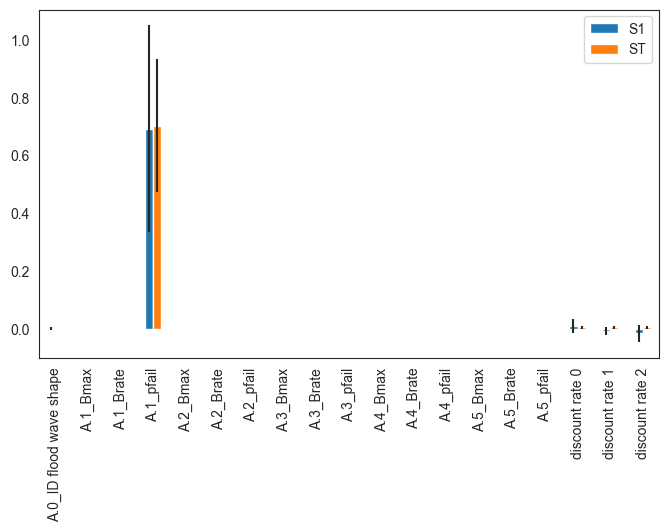

A.1_Expected Number of Deaths


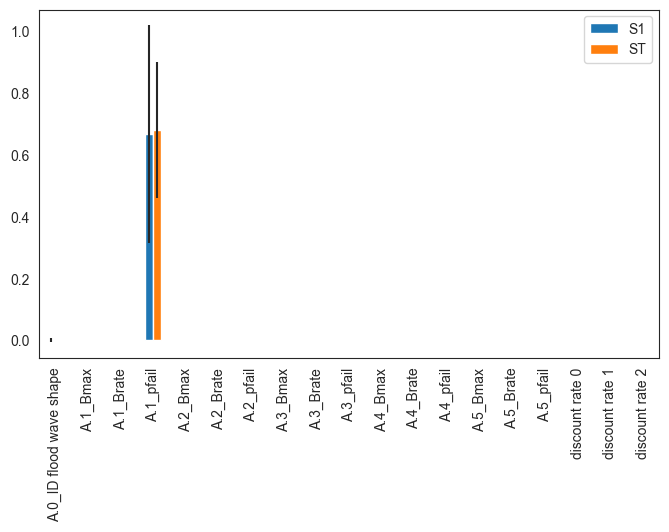

A.2 Total Costs


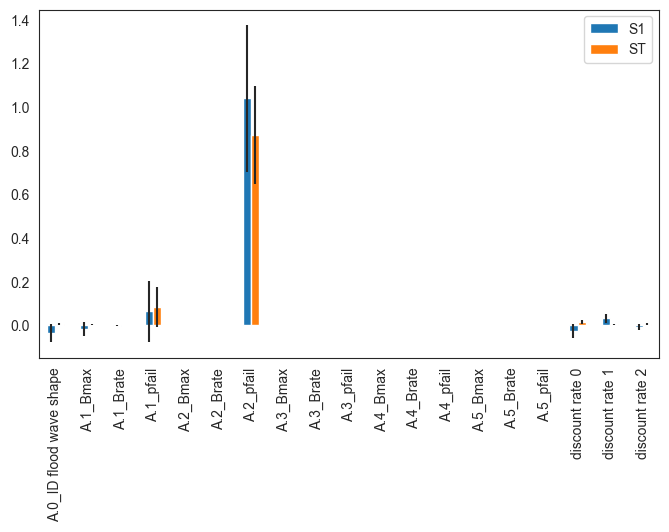

A.2_Expected Number of Deaths


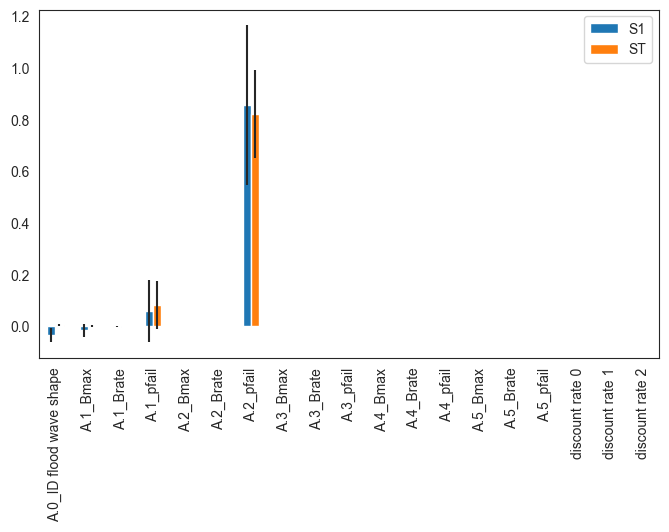

A.3 Total Costs


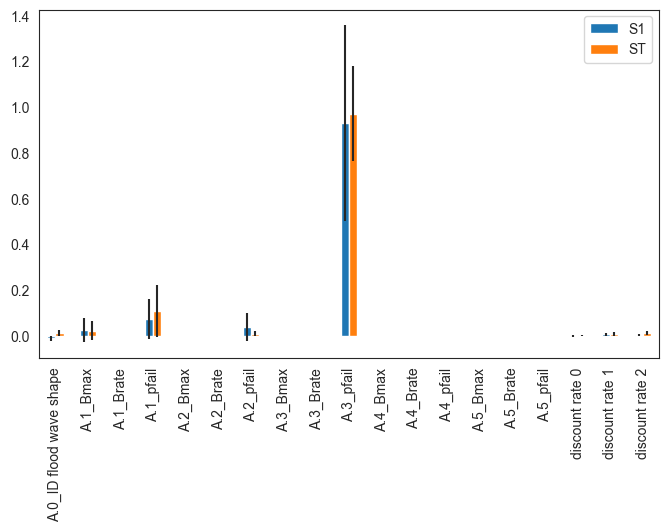

A.3_Expected Number of Deaths


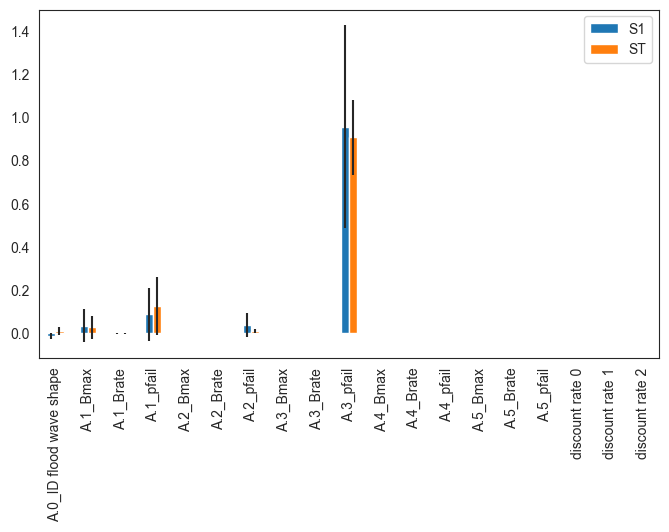

A.4 Total Costs


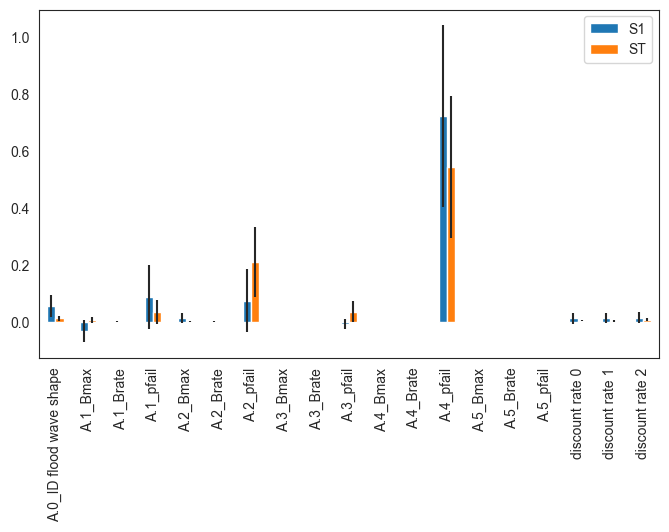

A.4_Expected Number of Deaths


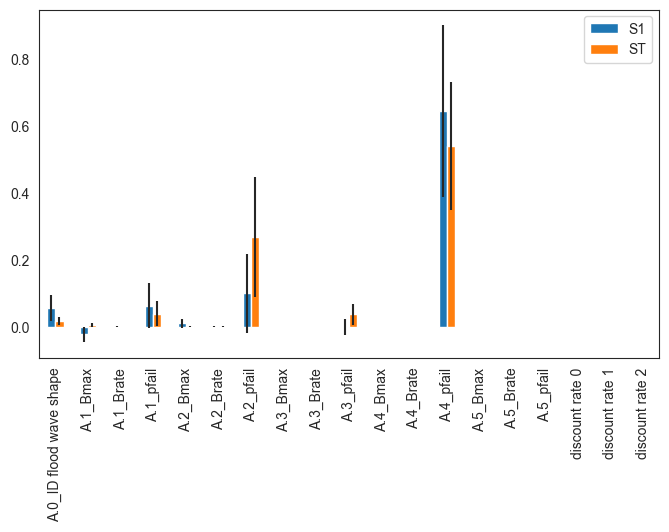

A.5 Total Costs


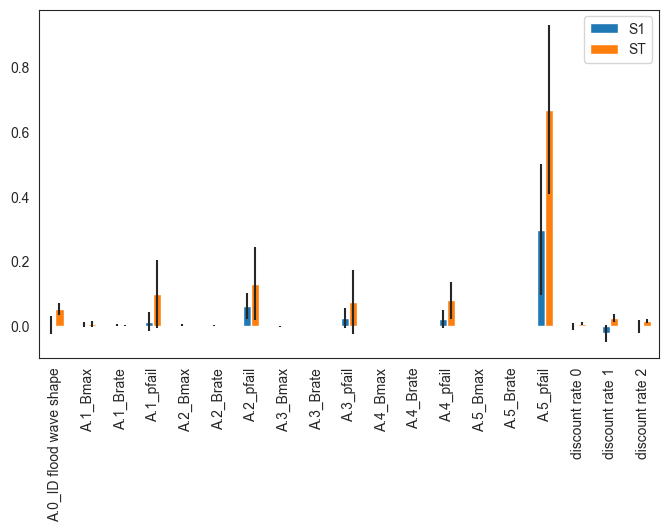

A.5_Expected Number of Deaths


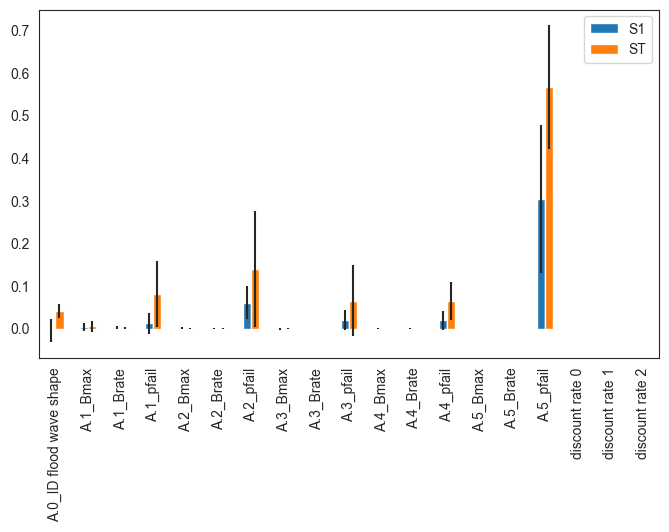

RfR Total Costs


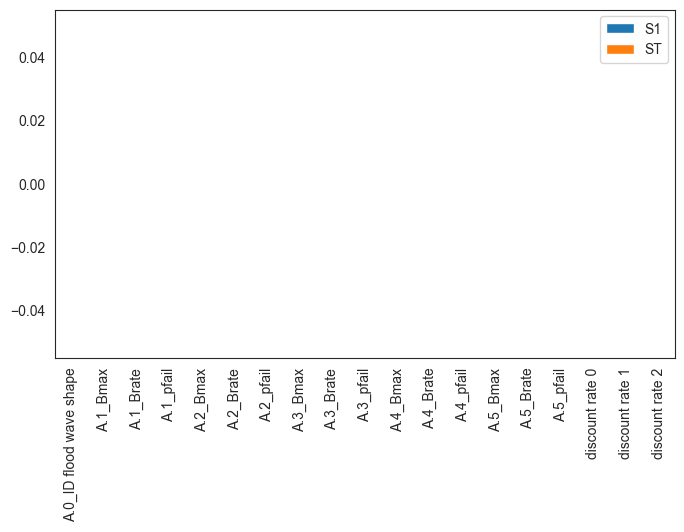

C:\Users\larsh\OneDrive - Delft University of Technology\Documenten\PyCharmDocs\ModelBasedDecisionMaking\Lib\site-packages\SALib\analyze\sobol.py:129: RuntimeWarning: invalid value encountered in divide
  Y = (Y - Y.mean()) / Y.std()


In [45]:
for key in res_df.keys():

    outcome_of_interest = key

    Si = sobol.analyze(problem, results[outcome_of_interest], calc_second_order=True, print_to_console=False)

    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names']).dropna()

    if len(Si_df) > 0:

        print(key)

        sns.set_style('white')
        fig, ax = plt.subplots(1)

        indices = Si_df[['S1','ST']]
        err = Si_df[['S1_conf','ST_conf']]

        indices.plot.bar(yerr=err.values.T,ax=ax)
        fig.set_size_inches(8,6)
        fig.subplots_adjust(bottom=0.3)
        plt.show()

In [77]:
# for key in res_df.keys():
#
#     outcome_of_interest = key
#
#     Si = sobol.analyze(problem, results[outcome_of_interest], calc_second_order=True, print_to_console=True)
#
#     Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
#     Si_df = pd.DataFrame(Si_filter, index=problem['names']).dropna()
#
#     if len(Si_df) > 0:
#
#         print(key)
#
#         sns.set_style('white')
#         fig, ax = plt.subplots(1)
#
#         indices = Si_df[['S1','ST']]
#         err = Si_df[['S1_conf','ST_conf']]
#
#         indices.plot.bar(yerr=err.values.T,ax=ax)
#         fig.set_size_inches(8,6)
#         fig.subplots_adjust(bottom=0.3)
#         plt.show()

AxisError: axis 1 is out of bounds for array of dimension 1

In [23]:
# Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
# Si_df = pd.DataFrame(Si_filter, index=problem['names'])
#
# sns.set_style('white')
# fig, ax = plt.subplots(1)
#
# indices = Si_df[['S1','ST']]
# err = Si_df[['S1_conf','ST_conf']]
#
# indices.plot.bar(yerr=err.values.T,ax=ax)
# fig.set_size_inches(8,6)
# fig.subplots_adjust(bottom=0.3)
# plt.show()